In [ ]:
import csv
import pandas as pd
import numpy as np
import spacy
import nltk
import ssl
import string
import networkx as nx

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')
nltk.download('stopwords')

In [2]:
def load_book(book_path, lower=False):

    with open(book_path, encoding="ISO-8859-1") as f:
        book = f.read()
    if lower:
        book = book.lower()
    return book

In [3]:
def get_sentence_sequences(book):

    detector = nltk.data.load('tokenizers/punkt/english.pickle')
    sentences = detector.tokenize(book)
    return sentences

In [4]:
def remove_punctuation(input_string):

    return input_string.translate(str.maketrans('', '', string.punctuation+'’'))


In [5]:
def extract_character_names(book):

    nlp = spacy.load("en_core_web_sm")
    stopwords = nltk.corpus.stopwords.words('english')

    words = [remove_punctuation(w) for w in book.split()]
    unique_words = list(set(words))

    characters = [word.text for word in nlp(' '.join(unique_words)) if word.pos_ == 'PROPN']
    characters = [c for c in characters if len(c) > 2]
    characters = [c for c in characters if c.istitle()]
    characters = [c for c in characters if not (c[-1] == 's' and c[:-1] in characters)]
    characters = list(set([c.title() for c in [c.lower() for c in characters]]) - set(stopwords))

    return [tuple([c + ' ']) for c in set(characters)]

In [6]:
def load_characters(charaters_path):

    with open(charaters_path) as f:
        reader = csv.reader(f)
        characters = [tuple(name+' ' for name in row) for row in reader]
    return characters

In [7]:
def find_connections(sequences, characters):

    if any(len(names) > 1 for names in characters):
        df = pd.DataFrame({str(character):
                           {sequence: sum([sequence.count(name) for name in character])
                            for sequence in sequences}
                           for character in characters})
    else:
        characters = [c[0] for c in characters]
        df = pd.DataFrame([[sequence.count(character)
                            for character in characters]
                           for sequence in sequences],
                          index=sequences,
                          columns=characters)
    return df

In [8]:
def calculate_cooccurence(df):

    characters = df.columns.values
    cooccurence = df.values.T.dot(df.values)
    np.fill_diagonal(cooccurence, 0)
    cooccurence = pd.DataFrame(cooccurence, columns=characters, index=characters)
    return cooccurence

In [9]:
def get_interaction_df(cooccurence, threshold):

    rows, columns = np.where(np.triu(cooccurence.values, 1) > threshold)
    return pd.DataFrame(np.column_stack([cooccurence.index[rows],
                                         cooccurence.columns[columns],
                                         cooccurence.values[rows, columns]]),
                        columns=['source', 'target', 'value'])

In [10]:
threshold = 2
book = load_book('/book.txt')
sequences = get_sentence_sequences(book)
## characters = extract_character_names(book)
characters = load_characters('/hp_characters.csv')
df = find_connections(sequences, characters)
cooccurence = calculate_cooccurence(df)
res = get_interaction_df(cooccurence, threshold)

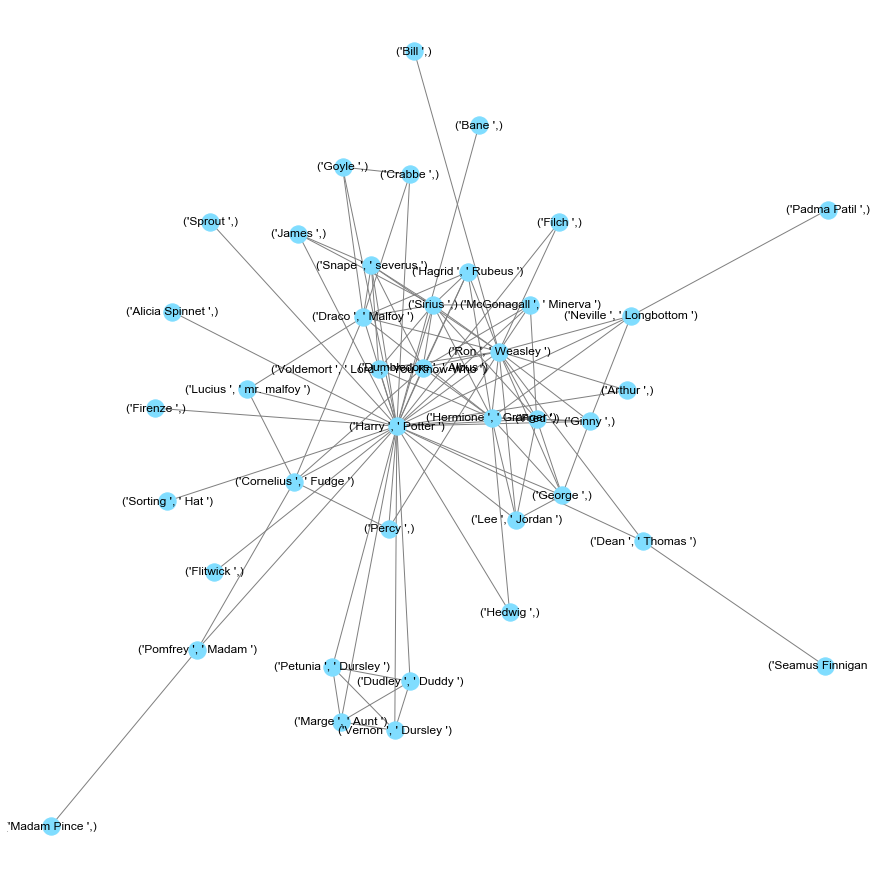

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12,12)
graph = nx.from_pandas_edgelist(res, source='source', target='target')
nx.draw(graph, with_labels=True, edge_color='#808080', node_color='#80ddff')
plt.savefig('/hp_sna.png')

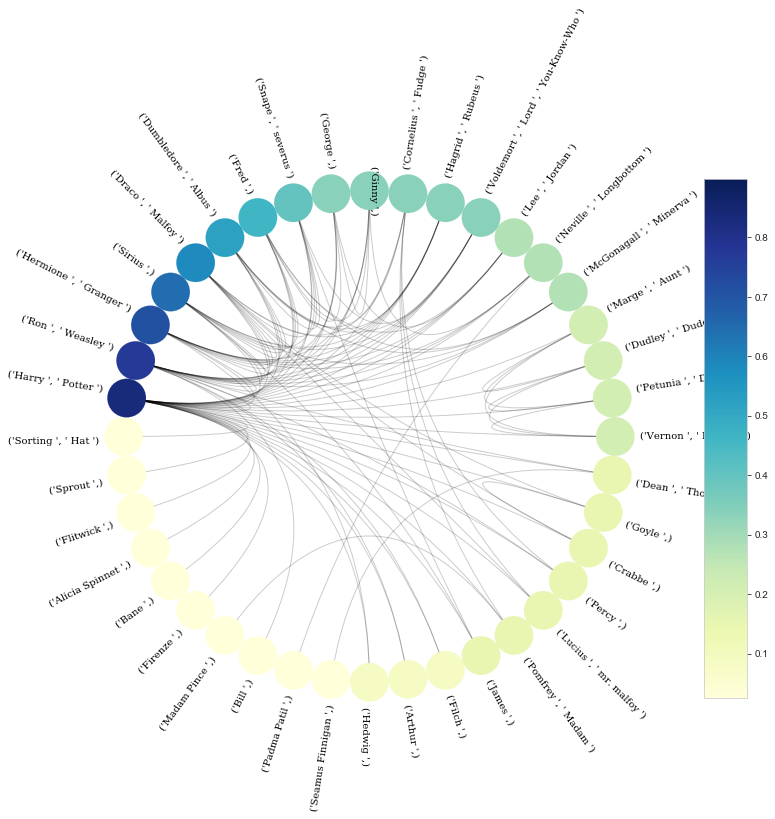

In [12]:
deg_cen = nx.degree_centrality(graph)
for node in graph.nodes():
    graph.nodes[node]['centrality'] = deg_cen[node]

import nxviz as nv
c = nv.CircosPlot(graph, node_labels=True, node_label_layout="rotation", node_color='centrality', node_order='centrality', figsize=(12,12), fontsize=10)
c.draw()
plt.savefig('/hp_sna_round.png')